In [1]:
import os
import geopandas as gpd          # for vector data (.shp, .prj, .dbf)
import pandas as pd              # for tabular data (.csv, .xls)
import rasterio                  # for raster data (.tif, .bil)
from rasterio.mask import mask   # for clipping rasters with shapefiles
import numpy as np               # for numeric operations
import matplotlib.pyplot as plt  # for visualization
import pyodbc                    # for reading MS Access (.mdb)

load shapefiles of algeria and tunisia 

In [2]:
 
# Load both shapefiles
dz = gpd.read_file("Datasets/Shapefiles/gadm41_DZA_shp")
tn = gpd.read_file("Datasets/Shapefiles/gadm41_TUN_shp")

# Check CRS (Coordinate Reference System)
print(dz.crs, tn.crs)

# Reproject Tunisia if CRS is different
if dz.crs != tn.crs:
    tn = tn.to_crs(dz.crs)

# Merge both into one GeoDataFrame
maghreb = gpd.GeoDataFrame(pd.concat([dz, tn], ignore_index=True))

# Optionally dissolve into one polygon (to treat as single shape)
maghreb_union = maghreb.dissolve()

# Save merged shapefile
maghreb_union.to_file("Datasets/Shapefiles/maghreb.shp")

print(" Merged shapefile saved as data/maghreb.shp")


C:\Users\ASUS\AppData\Roaming\Python\Python313\site-packages\pyogrio\geopandas.py:275: UserWarning: More than one layer found in 'gadm41_DZA_shp': 'gadm41_DZA_0' (default), 'gadm41_DZA_1', 'gadm41_DZA_2'. Specify layer parameter to avoid this warning.
  result = read_func(
C:\Users\ASUS\AppData\Roaming\Python\Python313\site-packages\pyogrio\geopandas.py:275: UserWarning: More than one layer found in 'gadm41_TUN_shp': 'gadm41_TUN_0' (default), 'gadm41_TUN_1', 'gadm41_TUN_2'. Specify layer parameter to avoid this warning.
  result = read_func(


EPSG:4326 EPSG:4326
 Merged shapefile saved as data/maghreb.shp


to clip worldwide datasets on algeria and tunisia aka maghrib 

In [3]:
def clip_raster(input_path, output_path, shapes):
    """Clip one raster using a shapefile polygon."""
    with rasterio.open(input_path) as src:
        out_image, out_transform = mask(src, shapes, crop=True)
        out_meta = src.meta.copy()
        out_meta.update({
            "driver": "GTiff",
            "height": out_image.shape[1],
            "width": out_image.shape[2],
            "transform": out_transform
        })
        with rasterio.open(output_path, "w", **out_meta) as dest:
            dest.write(out_image)
    print(f" Clipped: {os.path.basename(output_path)}")

Fire Dataset 

In [4]:
fire_dz = pd.read_csv("Datasets/Fire_Dataset/viirs-jpss1_2024_Algeria.csv")
fire_tn = pd.read_csv("Datasets/Fire_Dataset/viirs-jpss1_2024_Tunisia.csv")

# Combine both
fire = pd.concat([fire_dz, fire_tn], ignore_index=True)
fire.to_csv("data/processed/fire_maghreb.csv", index=False)

print("Fire dataset merged and saved.")

Fire dataset merged and saved.


In [5]:
print("📄 Fire DataFrame sample:")
print(f"  Fire dataset  {fire.shape[0]} rows")
print(fire.head())

📄 Fire DataFrame sample:
  Fire dataset  90250 rows
   latitude  longitude  bright_ti4  scan  track    acq_date  acq_time  \
0  27.72818    9.87200      295.51  0.76   0.77  2024-01-01         3   
1  28.63288    9.77909      301.80  0.79   0.78  2024-01-01         3   
2  28.64012    9.77953      298.65  0.79   0.78  2024-01-01         3   
3  36.74886    6.25409      338.04  0.46   0.39  2024-01-01       141   
4  35.87978    4.44782      309.49  0.41   0.37  2024-01-01       141   

  satellite instrument confidence  version  bright_ti5   frp daynight  type  
0       N20      VIIRS          n        2      277.66  1.24        N     2  
1       N20      VIIRS          n        2      277.05  1.57        N     2  
2       N20      VIIRS          n        2      277.04  1.34        N     2  
3       N20      VIIRS          n        2      257.28  5.21        N     2  
4       N20      VIIRS          n        2      272.08  1.58        N     2  


visualization 

In [6]:
'''fire_gdf = gpd.GeoDataFrame(
    fire, geometry=gpd.points_from_xy(fire["longitude"], fire["latitude"]), crs="EPSG:4326"
)

# --- Plot ---
fig, ax = plt.subplots(figsize=(8, 8))

# Base map: Maghreb boundaries
maghreb.boundary.plot(ax=ax, color="black", linewidth=1)

# Fire points
fire_gdf.plot(
    ax=ax,
    markersize=4,
    color="red",
    alpha=0.6,
    label="Fire Points"
)

# Title & labels
plt.title(" Fire Locations – Algeria & Tunisia (2020–2024)", fontsize=14)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend(loc="upper right")

plt.show()'''

'fire_gdf = gpd.GeoDataFrame(\n    fire, geometry=gpd.points_from_xy(fire["longitude"], fire["latitude"]), crs="EPSG:4326"\n)\n\n# --- Plot ---\nfig, ax = plt.subplots(figsize=(8, 8))\n\n# Base map: Maghreb boundaries\nmaghreb.boundary.plot(ax=ax, color="black", linewidth=1)\n\n# Fire points\nfire_gdf.plot(\n    ax=ax,\n    markersize=4,\n    color="red",\n    alpha=0.6,\n    label="Fire Points"\n)\n\n# Title & labels\nplt.title(" Fire Locations – Algeria & Tunisia (2020–2024)", fontsize=14)\nplt.xlabel("Longitude")\nplt.ylabel("Latitude")\nplt.legend(loc="upper right")\n\nplt.show()'

LANDCOVER dataset

In [7]:
import geopandas as gpd
import pandas as pd
import rasterio
from rasterio import features
from rasterio.transform import from_bounds
import numpy as np
import matplotlib.pyplot as plt

# --- 1️ Load shapefiles ---
landcover_dz = gpd.read_file("Datasets/Land_Cover/dza_gc_adg.shp")
landcover_tn = gpd.read_file("Datasets/Land_Cover/tun_gc_adg.shp")

# --- 2️ Load legends ---
legend_dz = pd.read_excel("Datasets/Land_Cover/globcover_LCCS_legend_africa.xls")
legend_tn = pd.read_excel("Datasets/Land_Cover/globcover_LCCS_legend_africa.xls")

# --- 3️ Convert all column names to lowercase ---
landcover_dz.columns = landcover_dz.columns.str.lower()
landcover_tn.columns = landcover_tn.columns.str.lower()
legend_dz.columns = legend_dz.columns.str.lower()
legend_tn.columns = legend_tn.columns.str.lower()

# --- 4️ Merge shapefiles with their legends ---
if 'lccs_code' in landcover_dz.columns and 'lccs_code' in legend_dz.columns:
    landcover_dz = landcover_dz.merge(legend_dz, on='lccs_code', how='left')
if 'lccs_code' in landcover_tn.columns and 'lccs_code' in legend_tn.columns:
    landcover_tn = landcover_tn.merge(legend_tn, on='lccs_code', how='left')

# --- 5️ Combine both into one GeoDataFrame ---
landcover = gpd.GeoDataFrame(pd.concat([landcover_dz, landcover_tn], ignore_index=True), crs=landcover_dz.crs)



In [8]:
print("📄 landcover DataFrame sample:")
print(f"  landcover dataset  {landcover.shape[0]} rows")
print(landcover.head())
print(landcover.info())

📄 landcover DataFrame sample:
  landcover dataset  438513 rows
   id  gridcode          area       lcccode  \
0   4       210  6.228187e+06  7001 // 8001   
1   2       210  6.242408e+06  7001 // 8001   
2   1       210  1.482995e+06  7001 // 8001   
3   8        50  4.590841e+08  21497-121340   
4  13       210  6.371533e+06  7001 // 8001   

                                            geometry  area_m2  
0  POLYGON ((6.41528 37.08696, 6.43103 37.0855, 6...      NaN  
1  POLYGON ((7.18084 37.07917, 7.17998 37.08091, ...      NaN  
2  POLYGON ((7.37137 37.08194, 7.3709 37.08717, 7...      NaN  
3  POLYGON ((6.12361 36.68472, 6.12361 36.69306, ...      NaN  
4  POLYGON ((6.26181 37.02361, 6.26193 37.02514, ...      NaN  
<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 438513 entries, 0 to 438512
Data columns (total 6 columns):
 #   Column    Non-Null Count   Dtype   
---  ------    --------------   -----   
 0   id        438513 non-null  int32   
 1   gridcode  438513 non-nul

In [9]:
'''
# --- Plot both datasets ---
fig, ax = plt.subplots(figsize=(10, 10))

# Base map: Maghreb boundaries
maghreb.boundary.plot(ax=ax, color="black", linewidth=1)

# Landcover polygons (colored by gridcode or lcccode)
landcover.plot(
    ax=ax,
    column='gridcode',  # or 'lcccode' for different coloring
    categorical=True,
    alpha=0.7,
    legend=True,
    cmap='tab20',  # Use a colormap with many distinct colors
    markersize=0.1
)
plt.title("Land Cover   – Algeria & Tunisia (2020–2024)", fontsize=14)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend(loc="upper right")
plt.show()
'''

'\n# --- Plot both datasets ---\nfig, ax = plt.subplots(figsize=(10, 10))\n\n# Base map: Maghreb boundaries\nmaghreb.boundary.plot(ax=ax, color="black", linewidth=1)\n\n# Landcover polygons (colored by gridcode or lcccode)\nlandcover.plot(\n    ax=ax,\n    column=\'gridcode\',  # or \'lcccode\' for different coloring\n    categorical=True,\n    alpha=0.7,\n    legend=True,\n    cmap=\'tab20\',  # Use a colormap with many distinct colors\n    markersize=0.1\n)\nplt.title("Land Cover   – Algeria & Tunisia (2020–2024)", fontsize=14)\nplt.xlabel("Longitude")\nplt.ylabel("Latitude")\nplt.legend(loc="upper right")\nplt.show()\n'

climate dataset

In [10]:
import os
import pandas as pd
import rasterio
from rasterio.transform import xy
import numpy as np

# =========================================================
# STEP 1. Define paths
# =========================================================
base_dir = "Datasets/Climate_Dataset"
climate_types = ["tmin", "tmax", "prec"]

# =========================================================
# STEP 2. Helper function to raster -> DataFrame
# =========================================================
def raster_to_df(raster_path, variable_name):
    """Convert raster (.tif) to DataFrame with lon, lat, and value columns."""
    with rasterio.open(raster_path) as src:
        data = src.read(1)
        mask = data != src.nodata
        rows, cols = np.where(mask)
        xs, ys = xy(src.transform, rows, cols)
        df = pd.DataFrame({
            "lon": xs,
            "lat": ys,
            variable_name: data[mask]
        })
    # Extract date from filename (assuming it contains year-month like 2020-01)
    name = os.path.basename(raster_path)
    date_part = name.split("_")[-2].replace("maghreb.tif", "")
    df["date"] = date_part
    return df

# =========================================================
# STEP 3. Loop through all climate types
# =========================================================
dfs = []
for ctype in climate_types:
    folder = os.path.join(base_dir, f"climate_{ctype}")
    files = sorted([os.path.join(folder, f) for f in os.listdir(folder) if f.endswith(".tif")])
    
    for fpath in files:
        df = raster_to_df(fpath, ctype)
        dfs.append(df)

# =========================================================
# STEP 4. Merge all datasets together
# =========================================================
# Combine all into one big DataFrame
climate_df = pd.concat(dfs, ignore_index=True)

# Pivot so each variable (tmin, tmax, prec) becomes a column
climate_df = (
    climate_df
    .pivot_table(index=["lon", "lat", "date"], 
                 values=["tmin", "tmax", "prec"], 
                 aggfunc="mean")
    .reset_index()
)

 
climate_df["date"] = pd.to_datetime(climate_df["date"], format="%Y-%m")
climate_df = climate_df[climate_df["date"].dt.year == 2024]







In [11]:
climate_df = climate_df.reset_index(drop=True)
print(" Combined climate DataFrame created!")
print(climate_df.head())
print(climate_df.info())

 Combined climate DataFrame created!
     lon        lat       date   prec   tmax   tmin
0 -8.625  27.291667 2024-01-01  2.000  22.00   8.00
1 -8.625  27.291667 2024-02-01  0.425  25.00  11.00
2 -8.625  27.291667 2024-03-01  0.500  27.00  13.00
3 -8.625  27.291667 2024-04-01  1.500  32.00  18.00
4 -8.625  27.291667 2024-05-01  0.000  33.25  19.25
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 393492 entries, 0 to 393491
Data columns (total 6 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   lon     393492 non-null  float64       
 1   lat     393492 non-null  float64       
 2   date    393492 non-null  datetime64[ns]
 3   prec    393492 non-null  float32       
 4   tmax    393492 non-null  float32       
 5   tmin    393492 non-null  float32       
dtypes: datetime64[ns](1), float32(3), float64(2)
memory usage: 13.5 MB
None


visualisation on the climate dataset

In [12]:
'''
plt.figure(figsize=(8, 6))
sc = plt.scatter(
    climate_df["lon"], climate_df["lat"],
    c=climate_df["tmax"], cmap="coolwarm", s=15
)
plt.colorbar(sc, label="TMAX (°C)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("TMAX – Maghreb Region")
plt.show()
'''

'\nplt.figure(figsize=(8, 6))\nsc = plt.scatter(\n    climate_df["lon"], climate_df["lat"],\n    c=climate_df["tmax"], cmap="coolwarm", s=15\n)\nplt.colorbar(sc, label="TMAX (°C)")\nplt.xlabel("Longitude")\nplt.ylabel("Latitude")\nplt.title("TMAX – Maghreb Region")\nplt.show()\n'

In [13]:
maghreb = gpd.read_file("Datasets/Shapefiles/maghreb.shp")
geoms = maghreb.geometry.values

soil dataset

In [14]:
import pyodbc
import pandas as pd
import geopandas as gpd
import rioxarray
import xarray
import rasterio
import numpy as np
import matplotlib.pyplot as plt

# =========================================================
# STEP 1. PATHS & CONNECTION
# =========================================================
mdb_path = r"Datasets/Soil_Dataset/HWSD2_DB/HWSD2.mdb"
raster_path = r"Datasets/Soil_Dataset/HWSD2_RASTER/HWSD2.bil"
#world_shp = r"../local_dataset/raw/world/ne_110m_admin_0_countries.shp"

# Connect to Access database
conn_str = f"DRIVER={{Microsoft Access Driver (*.mdb, *.accdb)}};DBQ={mdb_path};"
conn = pyodbc.connect(conn_str)

# Load soil layers table
layers = pd.read_sql("SELECT * FROM HWSD2_LAYERS", conn)
conn.close()

# Load world shapefile and soil raster
global world
world = gpd.read_file("Datasets/Shapefiles/maghreb.shp")
rds = rioxarray.open_rasterio(raster_path)

# =========================================================
# STEP 2. FUNCTION: Extract SMU IDs for given countries
# =========================================================
def extract_smu_ids():
    """Clip raster to Maghreb shapefile and extract SMU_ID coordinates."""
    #global world  # ensures it uses the global variable
    world_reproj = world.to_crs(rds.rio.crs)
    clipped = rds.rio.clip(world_reproj.geometry, from_disk=True)
    transform = clipped.rio.transform()

    rows, cols = np.indices(clipped.shape[1:])
    xs, ys = rasterio.transform.xy(transform, rows, cols)
    lons, lats = np.array(xs).flatten(), np.array(ys).flatten()
    smu_ids = clipped.values.flatten()

    mask = ~np.isnan(smu_ids)
    df = pd.DataFrame({
        "lon": lons[mask],
        "lat": lats[mask],
        "HWSD2_SMU_ID": smu_ids[mask].astype(int)
    })
    return df


# =========================================================
# STEP 3. FUNCTION: Filter layers by SMU_IDs
# =========================================================
def filter_smu_layers(smu_ids_df):
    """Filter HWSD2_LAYERS table to include only selected SMU_IDs."""
    selected_ids = smu_ids_df["HWSD2_SMU_ID" ].unique()
    layers_filtered = layers[layers["HWSD2_SMU_ID"].isin(selected_ids)]
    layers_merged = pd.merge(
        layers_filtered,
        smu_ids_df[["HWSD2_SMU_ID", "lat", "lon"]],
        on="HWSD2_SMU_ID",
        how="left"
    )
    return layers_merged

# =========================================================
# STEP 4. EXTRACT DATA FOR ALGERIA + TUNISIA
# =========================================================
print("🗺️ Extracting SMU IDs for Algeria & Tunisia...")
smu_ids = extract_smu_ids()
print(smu_ids.head)
print(f" Extracted {len(smu_ids)} SMU pixel points")

# Compute centroid per SMU
smu_ids = smu_ids.drop_duplicates(subset="HWSD2_SMU_ID").reset_index(drop=True)

print(f" Unique SMU IDs: {len(smu_ids)}")

# Filter soil layers for selected SMU IDs
layers = filter_smu_layers(smu_ids)
print(f" Filtered layers: {layers.shape[0]} rows")
print(f" layers head # {layers.head()}")
# =========================================================
# STEP 5. FILTER LAYER D1 AND SELECT USEFUL COLUMNS
# =========================================================
layers = layers[layers["LAYER"] == "D1"]

useful_columns = [
     'lat','lon',"HWSD2_SMU_ID", "COARSE", "SAND", "SILT", "CLAY", "TEXTURE_USDA",
    "TEXTURE_SOTER", "BULK", "REF_BULK", "ORG_CARBON", "PH_WATER",
    "TOTAL_N", "CN_RATIO", "CEC_SOIL", "CEC_CLAY", "CEC_EFF",
    "TEB", "BSAT", "ALUM_SAT", "ESP", "TCARBON_EQ", "GYPSUM", "ELEC_COND",'LAYER'
]
layers = layers[useful_columns]

print("✅ Column filtering complete")
print(layers.head())


C:\Users\ASUS\AppData\Local\Temp\ipykernel_14728\3117962792.py:22: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  layers = pd.read_sql("SELECT * FROM HWSD2_LAYERS", conn)


🗺️ Extracting SMU IDs for Algeria & Tunisia...
<bound method NDFrame.head of                lon      lat  HWSD2_SMU_ID
0        -8.670833  37.5625         65535
1        -8.662500  37.5625         65535
2        -8.654167  37.5625         65535
3        -8.645833  37.5625         65535
4        -8.637500  37.5625         65535
...            ...      ...           ...
5537835  11.954167  18.9625         65535
5537836  11.962500  18.9625         65535
5537837  11.970833  18.9625         65535
5537838  11.979167  18.9625         65535
5537839  11.987500  18.9625         65535

[5537840 rows x 3 columns]>
 Extracted 5537840 SMU pixel points
 Unique SMU IDs: 386
 Filtered layers: 6027 rows
 layers head #       ID  HWSD2_SMU_ID NSC_MU_SOURCE1 NSC_MU_SOURCE2 WISE30s_SMU_ID  \
0  12264         31816           None           None     WD30031816   
1  12265         31801           None           None     WD30031801   
2  12266         31802           None           None     WD30031802   
3  122

elevation

In [15]:
import rasterio
from rasterio.mask import mask
import geopandas as gpd
import os

# Load shapefile (already merged)
# maghreb = gpd.read_file("data/shapes/maghreb.shp")

geoms = maghreb.geometry.values

# Input path: the FOLDER containing the .adf files
raster_path = "Datasets/Elevation_Dataset/be15_grd/be15_grd"

# Output
os.makedirs("data/processed", exist_ok=True)
out_path = "data/processed/elevation_maghreb.tif"

# Clip raster
with rasterio.open(raster_path) as src:
    out_image, out_transform = mask(src, geoms, crop=True)
    out_meta = src.meta.copy()
    out_meta.update({
        "driver": "GTiff",
        "height": out_image.shape[1],
        "width": out_image.shape[2],
        "transform": out_transform
    })

    with rasterio.open(out_path, "w", **out_meta) as dest:
        dest.write(out_image)

print("✅ Clipped elevation raster saved:", out_path)


✅ Clipped elevation raster saved: data/processed/elevation_maghreb.tif


In [16]:
import rasterio
import numpy as np
import pandas as pd

# --- Read the clipped raster ---
raster_path = "data/processed/elevation_maghreb.tif"

with rasterio.open(raster_path) as src:
    band = src.read(1)  # first (and only) band
    transform = src.transform

# --- Get coordinates of each pixel ---
rows, cols = np.where(~np.isnan(band))  # ignore no-data cells
xs, ys = rasterio.transform.xy(transform, rows, cols)

# --- Build DataFrame ---
df_elev = pd.DataFrame({
    "lon": xs,
    "lat": ys,
    "elevation": band[rows, cols]
})

print(df_elev.head())
print(df_elev.shape)


        lon        lat  elevation
0 -8.673056  37.560278     -32768
1 -8.668889  37.560278     -32768
2 -8.664722  37.560278     -32768
3 -8.660556  37.560278     -32768
4 -8.656389  37.560278     -32768
(22146400, 3)


In [17]:
'''
with rasterio.open("data/processed/elevation_maghreb.tif") as src:
    plt.imshow(src.read(1), cmap="terrain")
    plt.title("Elevation – Algeria + Tunisia")
    plt.colorbar(label="meters")
    plt.show()

print(" All datasets processed successfully.")
'''

'\nwith rasterio.open("data/processed/elevation_maghreb.tif") as src:\n    plt.imshow(src.read(1), cmap="terrain")\n    plt.title("Elevation – Algeria + Tunisia")\n    plt.colorbar(label="meters")\n    plt.show()\n\nprint(" All datasets processed successfully.")\n'

In [18]:
import xarray as xr
import rioxarray

# Example for one dataset (e.g., soil sand content)
tif_path = "data/processed/elevation_maghreb.tif"
nc_path = "NC_Files/elevation_maghreb.nc"

# Load GeoTIFF
data = rioxarray.open_rasterio(tif_path)

# Set variable name (optional)
data.name = "soil_sand"

# Save to NetCDF
data.to_netcdf(nc_path)

print(" Saved as NetCDF:", nc_path)


 Saved as NetCDF: NC_Files/elevation_maghreb.nc


In [19]:

import glob
tif_files = glob.glob("Datasets/Climate_Dataset/climate_tmax/wc2.1_cruts4.09_5m_tmax_*_maghreb.tif")

# Load each .tif as DataArray and rename variable
data_arrays = []
for f in tif_files:
    var_name = f.split("_")[-2]  # e.g., soil_sand_maghreb -> "sand"
    da = rioxarray.open_rasterio(f)
    da.name = var_name
    data_arrays.append(da)

# Merge into one dataset
ds = xr.merge(data_arrays)

ds.to_netcdf("NC_Files/climate_tmax.nc")

print(" All soil variables saved in one NetCDF file!")

 All soil variables saved in one NetCDF file!


C:\Users\ASUS\AppData\Local\Temp\ipykernel_14728\3613267825.py:13: FutureWarning: In a future version of xarray the default value for compat will change from compat='no_conflicts' to compat='override'. This is likely to lead to different results when combining overlapping variables with the same name. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set compat explicitly.
  ds = xr.merge(data_arrays)


In [20]:
import xarray as xr

# Example: load your temperature file
ds = xr.open_dataset("NC_Files/climate_tmax.nc")
print(ds)


<xarray.Dataset> Size: 13MB
Dimensions:      (band: 1, y: 224, x: 249)
Coordinates:
  * band         (band) int32 4B 1
  * y            (y) float64 2kB 37.54 37.46 37.38 37.29 ... 19.13 19.04 18.96
  * x            (x) float64 2kB -8.708 -8.625 -8.542 ... 11.79 11.87 11.96
Data variables: (12/61)
    2020-01      (band, y, x) float32 223kB ...
    2020-02      (band, y, x) float32 223kB ...
    2020-03      (band, y, x) float32 223kB ...
    2020-04      (band, y, x) float32 223kB ...
    2020-05      (band, y, x) float32 223kB ...
    2020-06      (band, y, x) float32 223kB ...
    ...           ...
    2024-08      (band, y, x) float32 223kB ...
    2024-09      (band, y, x) float32 223kB ...
    2024-10      (band, y, x) float32 223kB ...
    2024-11      (band, y, x) float32 223kB ...
    2024-12      (band, y, x) float32 223kB ...
    spatial_ref  int32 4B ...
Attributes:
    AREA_OR_POINT:  Area
    _FillValue:     nan
    scale_factor:   1.0
    add_offset:     0.0


In [21]:
'''
import glob
import xarray as xr
import matplotlib.pyplot as plt

nc_files = glob.glob("NC_Files/*.nc")

for f in nc_files:
    ds = xr.open_dataset(f)
    var_name = list(ds.data_vars.keys())[0]
    data = ds[var_name].isel(band=0)
    plt.figure(figsize=(6, 5))
    data.plot(cmap="terrain")
    plt.title(f"{var_name} ({f.split('/')[-1]})")
    plt.show()
    '''


'\nimport glob\nimport xarray as xr\nimport matplotlib.pyplot as plt\n\nnc_files = glob.glob("NC_Files/*.nc")\n\nfor f in nc_files:\n    ds = xr.open_dataset(f)\n    var_name = list(ds.data_vars.keys())[0]\n    data = ds[var_name].isel(band=0)\n    plt.figure(figsize=(6, 5))\n    data.plot(cmap="terrain")\n    plt.title(f"{var_name} ({f.split(\'/\')[-1]})")\n    plt.show()\n    '

In [22]:
'''
# convert the fire into nc file 

import pandas as pd
import geopandas as gpd
from rasterio.transform import from_origin
import rasterio
import numpy as np

# --- Load your merged fire CSV ---
fire = pd.read_csv("data/processed/fire_maghreb.csv")

# --- Make sure the columns are named correctly ---
# Rename columns if needed
fire.rename(columns={'latitude': 'lat', 'longitude': 'lon'}, inplace=True)

# --- Convert to GeoDataFrame ---
gdf = gpd.GeoDataFrame(
    fire, geometry=gpd.points_from_xy(fire['lon'], fire['lat']), crs="EPSG:4326"
)

# --- Define raster resolution (in degrees for WGS84) ---
cell_size = 0.05  # ~5 km grid

# --- Define grid bounds ---
xmin, ymin, xmax, ymax = gdf.total_bounds

# --- Calculate number of pixels in each direction ---
ncols = int((xmax - xmin) / cell_size)
nrows = int((ymax - ymin) / cell_size)

# --- Create empty raster array ---
raster = np.zeros((nrows, ncols), dtype=np.float32)

# --- Fill raster: count fires per cell ---
for _, point in gdf.iterrows():
    col = int((point.geometry.x - xmin) / cell_size)
    row = int((ymax - point.geometry.y) / cell_size)
    if 0 <= row < nrows and 0 <= col < ncols:
        raster[row, col] += 1

# --- Define transform ---
transform = from_origin(xmin, ymax, cell_size, cell_size)

# --- Save to GeoTIFF ---
out_path = "data/processed/fire_maghreb.tif"
with rasterio.open(
    out_path,
    'w',
    driver='GTiff',
    height=raster.shape[0],
    width=raster.shape[1],
    count=1,
    dtype=raster.dtype,
    crs="EPSG:4326",
    transform=transform
) as dst:
    dst.write(raster, 1)

print(" Fire data rasterized and saved as:", out_path)
'''

'\n# convert the fire into nc file \n\nimport pandas as pd\nimport geopandas as gpd\nfrom rasterio.transform import from_origin\nimport rasterio\nimport numpy as np\n\n# --- Load your merged fire CSV ---\nfire = pd.read_csv("data/processed/fire_maghreb.csv")\n\n# --- Make sure the columns are named correctly ---\n# Rename columns if needed\nfire.rename(columns={\'latitude\': \'lat\', \'longitude\': \'lon\'}, inplace=True)\n\n# --- Convert to GeoDataFrame ---\ngdf = gpd.GeoDataFrame(\n    fire, geometry=gpd.points_from_xy(fire[\'lon\'], fire[\'lat\']), crs="EPSG:4326"\n)\n\n# --- Define raster resolution (in degrees for WGS84) ---\ncell_size = 0.05  # ~5 km grid\n\n# --- Define grid bounds ---\nxmin, ymin, xmax, ymax = gdf.total_bounds\n\n# --- Calculate number of pixels in each direction ---\nncols = int((xmax - xmin) / cell_size)\nnrows = int((ymax - ymin) / cell_size)\n\n# --- Create empty raster array ---\nraster = np.zeros((nrows, ncols), dtype=np.float32)\n\n# --- Fill raster: cou

# Analyse exploratoire

In [23]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns

# Vérifier les types et tailles
datasets = {
    "fire": fire,
    "climate": climate_df,
    "elevation": df_elev,
    "soil": layers,
    "landcover": landcover
}

for name, df in datasets.items():
    print(f"\n {name.upper()} — Shape: {df.shape}")
    print(df.info())
    print(df.describe(include='all').T.head())



 FIRE — Shape: (90250, 15)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90250 entries, 0 to 90249
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   latitude    90250 non-null  float64
 1   longitude   90250 non-null  float64
 2   bright_ti4  90250 non-null  float64
 3   scan        90250 non-null  float64
 4   track       90250 non-null  float64
 5   acq_date    90250 non-null  object 
 6   acq_time    90250 non-null  int64  
 7   satellite   90250 non-null  object 
 8   instrument  90250 non-null  object 
 9   confidence  90250 non-null  object 
 10  version     90250 non-null  int64  
 11  bright_ti5  90250 non-null  float64
 12  frp         90250 non-null  float64
 13  daynight    90250 non-null  object 
 14  type        90250 non-null  int64  
dtypes: float64(7), int64(3), object(5)
memory usage: 10.3+ MB
None
              count unique  top freq        mean        std       min  \
latitude    90250.0    Na

# Fire Dataset Visualization

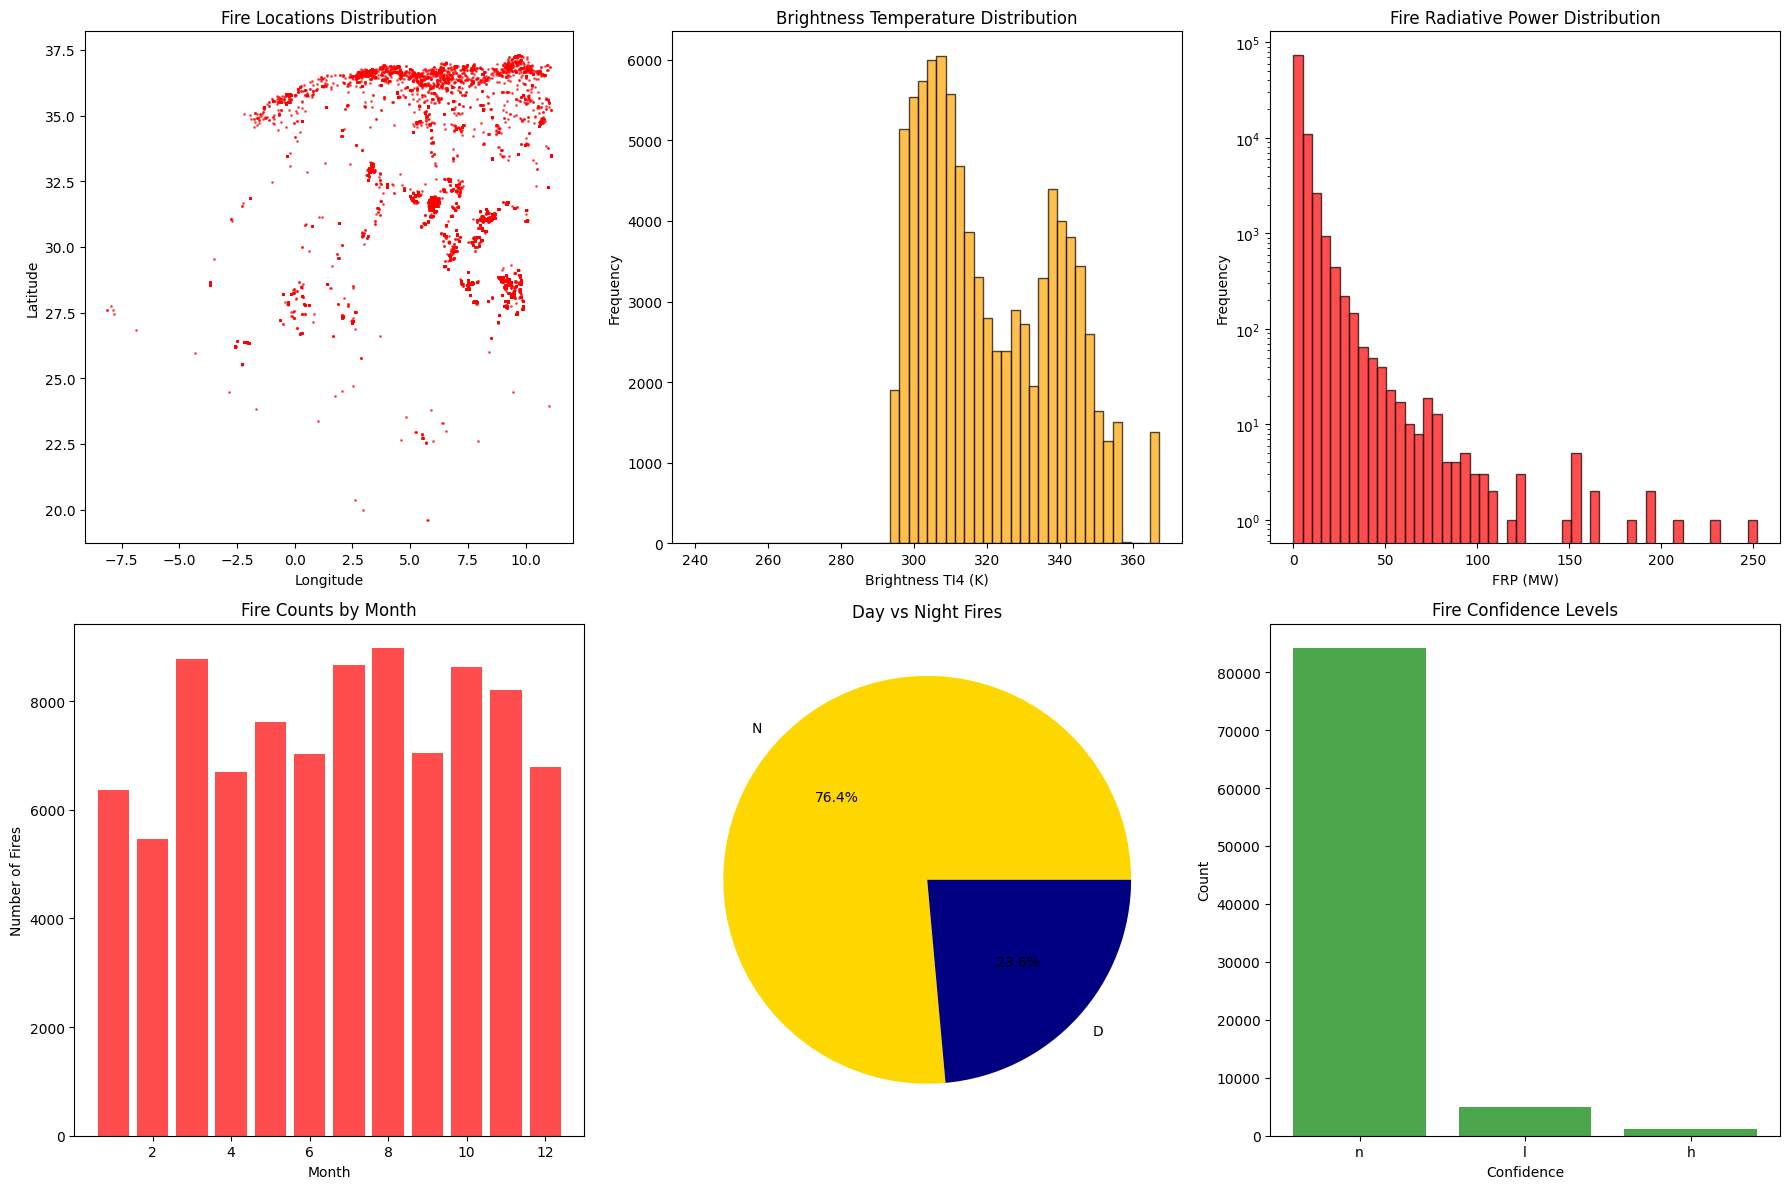

In [24]:
# Convert acq_date to datetime
fire['acq_date'] = pd.to_datetime(fire['acq_date'])

# Create subplots
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1.1 Fire locations map
fire_gdf = gpd.GeoDataFrame(
    fire, 
    geometry=gpd.points_from_xy(fire.longitude, fire.latitude), 
    crs="EPSG:4326"
)
fire_gdf.plot(ax=axes[0,0], markersize=1, color='red', alpha=0.6)
axes[0,0].set_title("Fire Locations Distribution")
axes[0,0].set_xlabel("Longitude")
axes[0,0].set_ylabel("Latitude")

# 1.2 Brightness temperature distribution
axes[0,1].hist(fire['bright_ti4'], bins=50, color='orange', alpha=0.7, edgecolor='black')
axes[0,1].set_title("Brightness Temperature Distribution")
axes[0,1].set_xlabel("Brightness TI4 (K)")
axes[0,1].set_ylabel("Frequency")

# 1.3 Fire Radiative Power (FRP)
axes[0,2].hist(fire['frp'], bins=50, color='red', alpha=0.7, edgecolor='black')
axes[0,2].set_title("Fire Radiative Power Distribution")
axes[0,2].set_xlabel("FRP (MW)")
axes[0,2].set_ylabel("Frequency")
axes[0,2].set_yscale('log')  # Log scale for better visualization

# 1.4 Temporal distribution (monthly)
fire['month'] = fire['acq_date'].dt.month
monthly_counts = fire['month'].value_counts().sort_index()
axes[1,0].bar(monthly_counts.index, monthly_counts.values, color='red', alpha=0.7)
axes[1,0].set_title("Fire Counts by Month")
axes[1,0].set_xlabel("Month")
axes[1,0].set_ylabel("Number of Fires")

# 1.5 Day/Night distribution
daynight_counts = fire['daynight'].value_counts()
axes[1,1].pie(daynight_counts.values, labels=daynight_counts.index, autopct='%1.1f%%', 
              colors=['gold', 'navy'])
axes[1,1].set_title("Day vs Night Fires")

# 1.6 Confidence levels
confidence_counts = fire['confidence'].value_counts()
axes[1,2].bar(confidence_counts.index, confidence_counts.values, color='green', alpha=0.7)
axes[1,2].set_title("Fire Confidence Levels")
axes[1,2].set_xlabel("Confidence")
axes[1,2].set_ylabel("Count")

plt.tight_layout()
plt.show()

# Climate Dataset Visualization

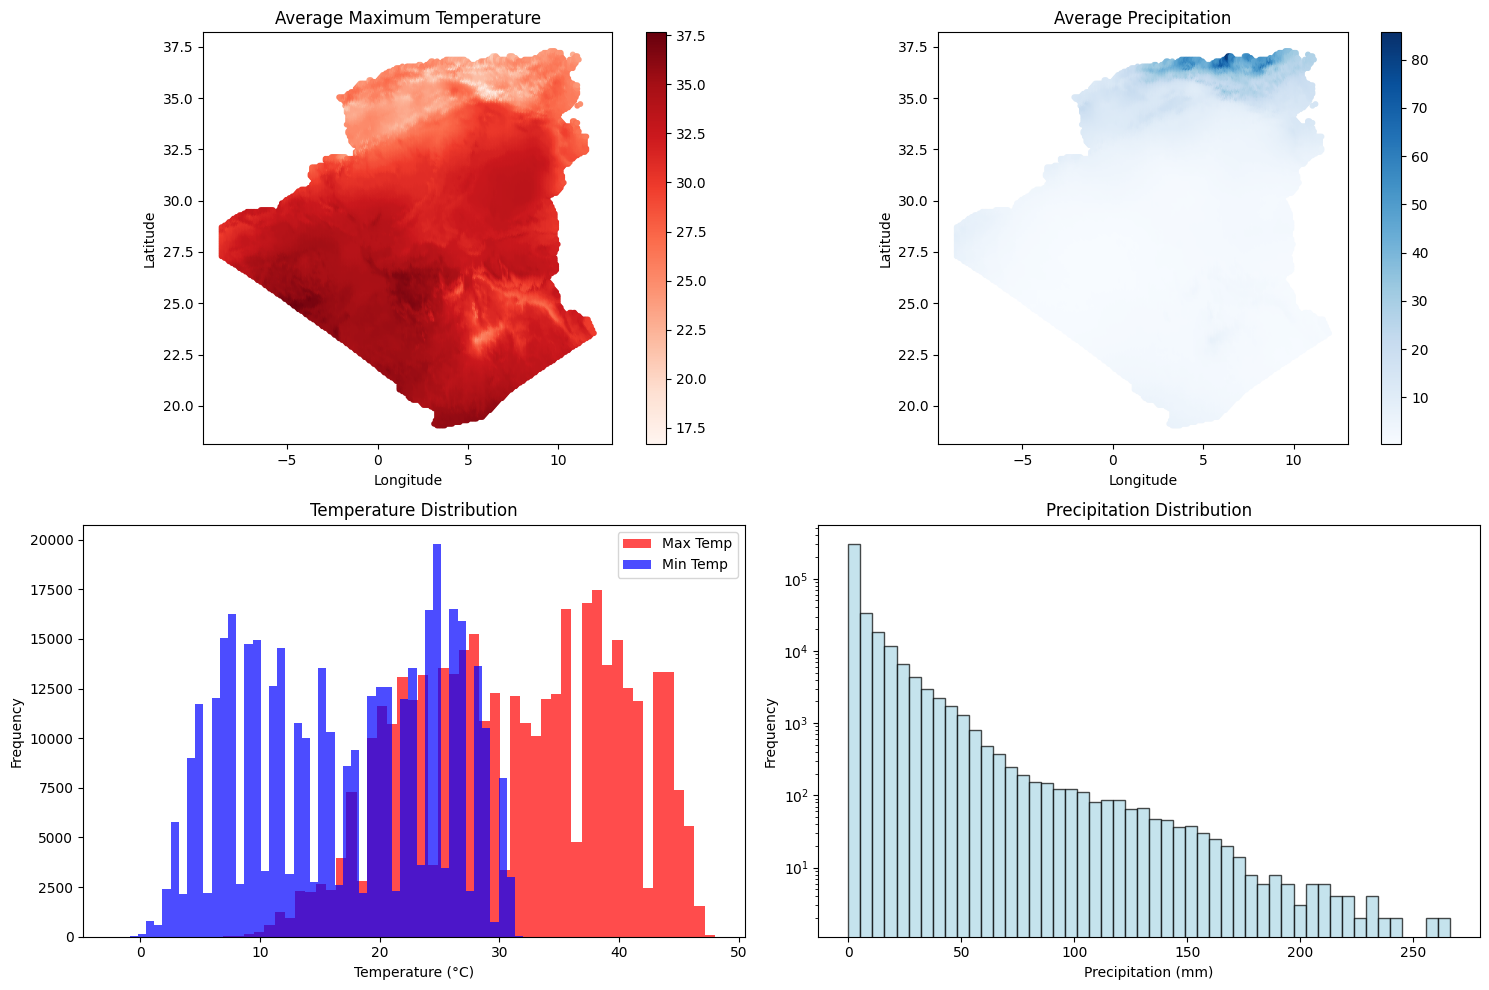

In [25]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 2.1 Temperature map (average tmax)
climate_gdf = gpd.GeoDataFrame(
    climate_df, 
    geometry=gpd.points_from_xy(climate_df.lon, climate_df.lat), 
    crs="EPSG:4326"
)

# Plot average maximum temperature
avg_tmax = climate_df.groupby(['lon', 'lat'])['tmax'].mean().reset_index()
avg_tmax_gdf = gpd.GeoDataFrame(
    avg_tmax, 
    geometry=gpd.points_from_xy(avg_tmax.lon, avg_tmax.lat), 
    crs="EPSG:4326"
)
avg_tmax_gdf.plot(column='tmax', ax=axes[0,0], legend=True, cmap='Reds', markersize=10)
axes[0,0].set_title("Average Maximum Temperature")
axes[0,0].set_xlabel("Longitude")
axes[0,0].set_ylabel("Latitude")

# 2.2 Precipitation map
avg_prec = climate_df.groupby(['lon', 'lat'])['prec'].mean().reset_index()
avg_prec_gdf = gpd.GeoDataFrame(
    avg_prec, 
    geometry=gpd.points_from_xy(avg_prec.lon, avg_prec.lat), 
    crs="EPSG:4326"
)
avg_prec_gdf.plot(column='prec', ax=axes[0,1], legend=True, cmap='Blues', markersize=10)
axes[0,1].set_title("Average Precipitation")
axes[0,1].set_xlabel("Longitude")
axes[0,1].set_ylabel("Latitude")

# 2.3 Temperature distribution
axes[1,0].hist(climate_df['tmax'], bins=50, alpha=0.7, color='red', label='Max Temp')
axes[1,0].hist(climate_df['tmin'], bins=50, alpha=0.7, color='blue', label='Min Temp')
axes[1,0].set_title("Temperature Distribution")
axes[1,0].set_xlabel("Temperature (°C)")
axes[1,0].set_ylabel("Frequency")
axes[1,0].legend()

# 2.4 Precipitation distribution
axes[1,1].hist(climate_df['prec'], bins=50, color='lightblue', alpha=0.7, edgecolor='black')
axes[1,1].set_title("Precipitation Distribution")
axes[1,1].set_xlabel("Precipitation (mm)")
axes[1,1].set_ylabel("Frequency")
axes[1,1].set_yscale('log')

plt.tight_layout()
plt.show()

# Soil Dataset Visualization

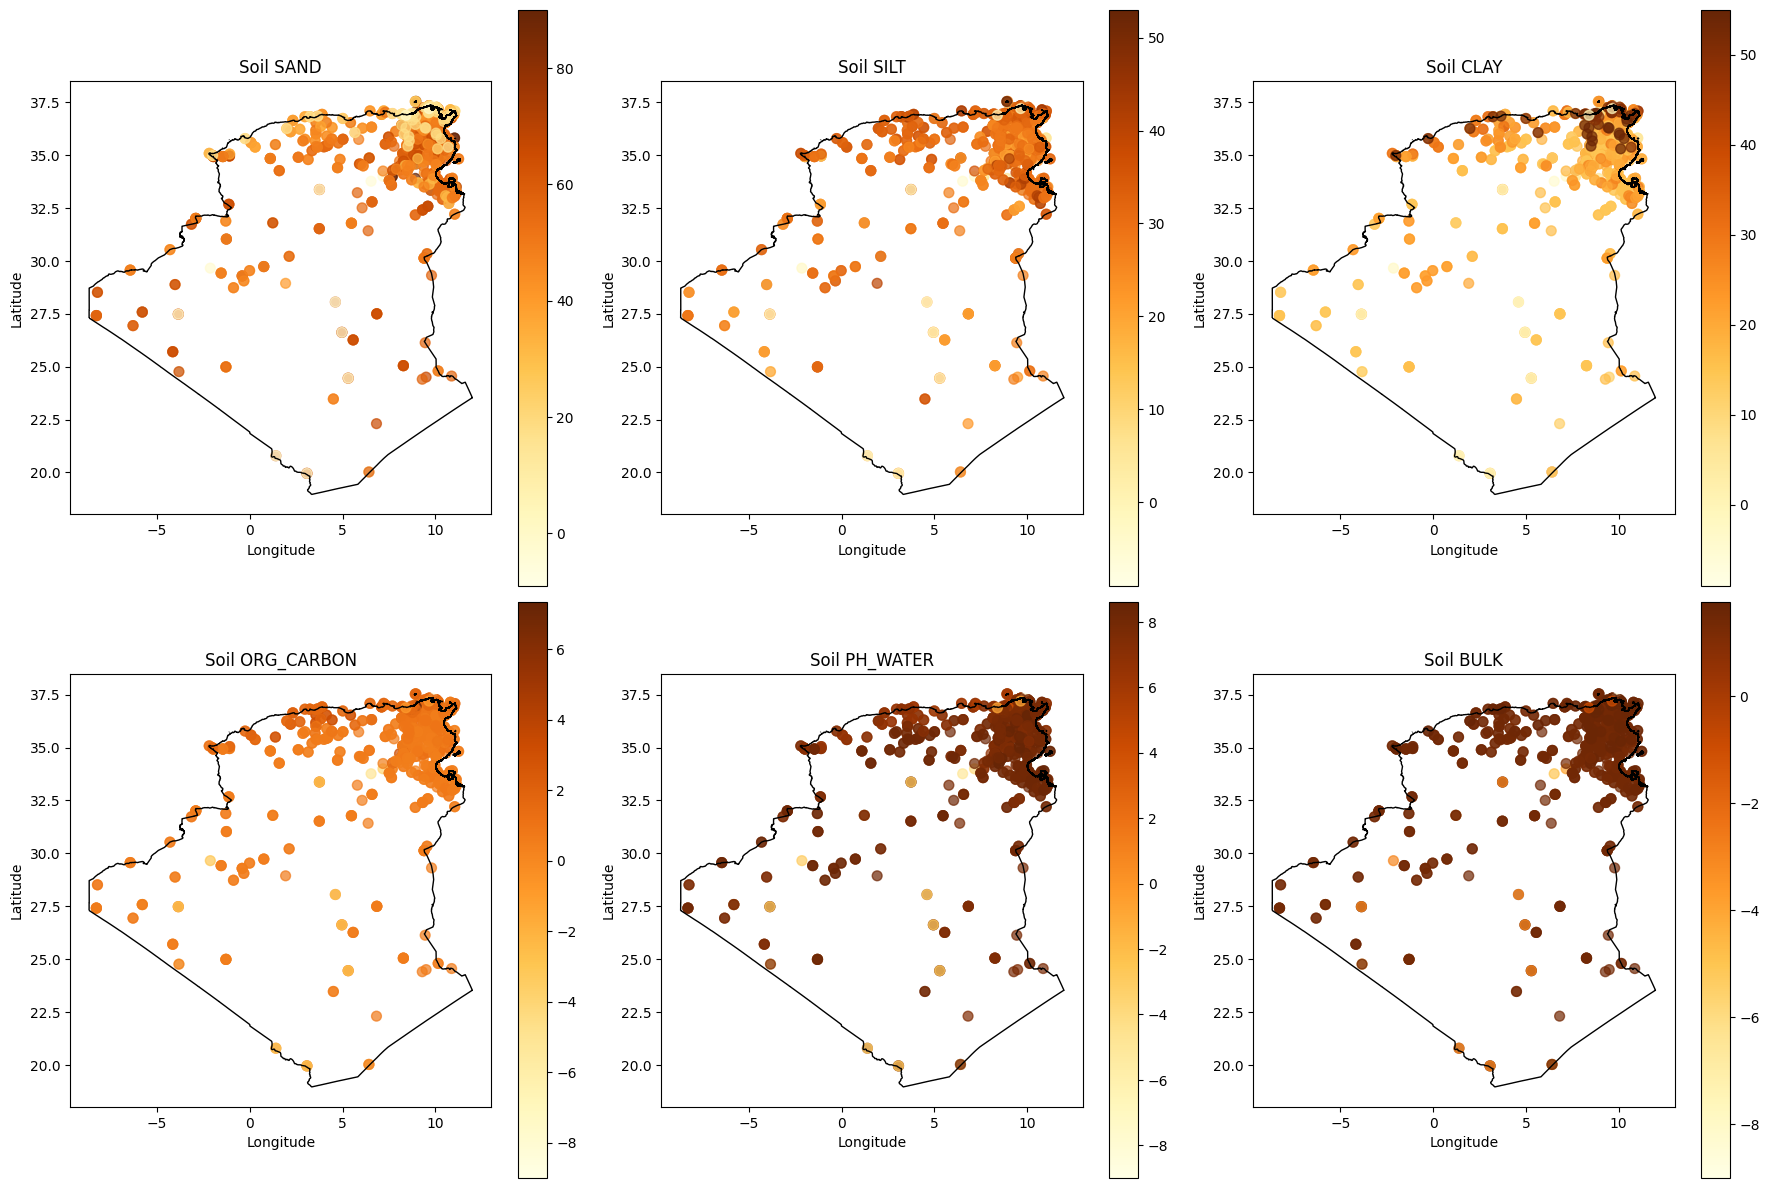

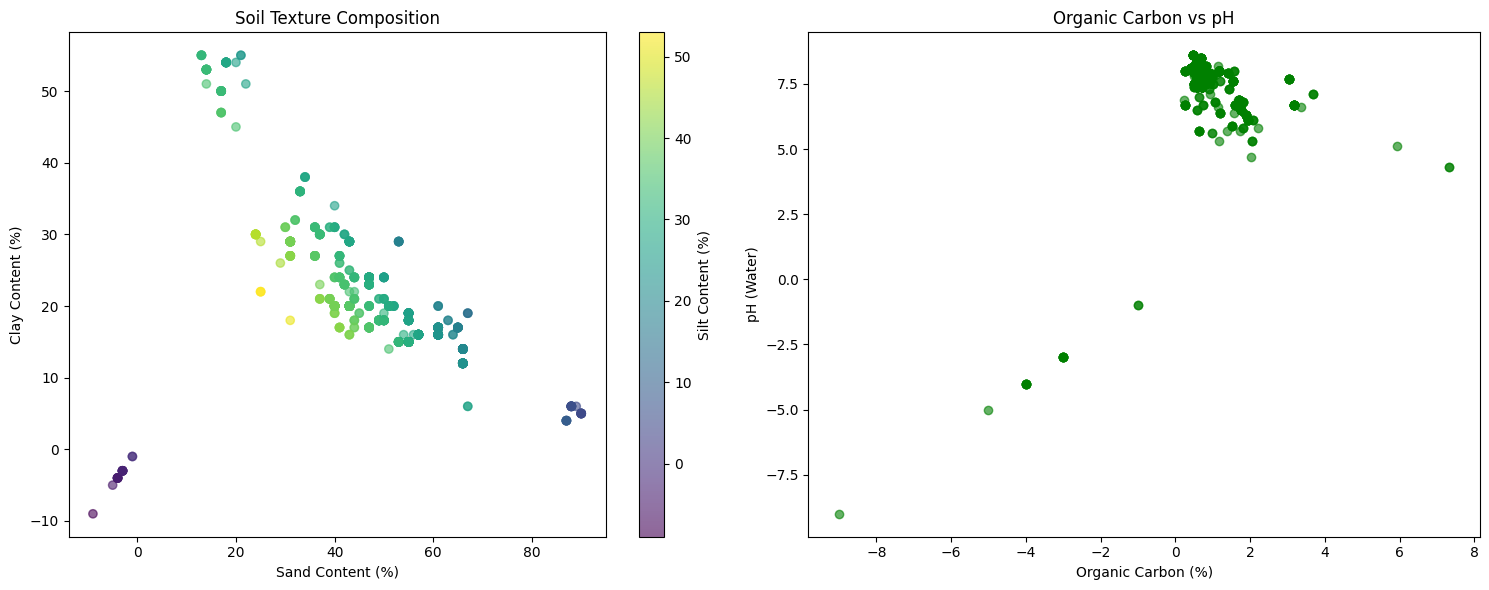

In [26]:
# Select key soil properties for visualization
soil_properties = ['SAND', 'SILT', 'CLAY', 'ORG_CARBON', 'PH_WATER', 'BULK']

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.ravel()

for i, prop in enumerate(soil_properties):
    if i < len(axes):
        # Soil property map
        soil_gdf = gpd.GeoDataFrame(
            layers, 
            geometry=gpd.points_from_xy(layers.lon, layers.lat), 
            crs="EPSG:4326"
        )
        maghreb.boundary.plot(ax=axes[i], color="black", linewidth=1)
        soil_gdf.plot(column=prop, ax=axes[i], legend=True, cmap='YlOrBr', 
                     markersize=50, alpha=0.7)
        axes[i].set_title(f"Soil {prop}")
        axes[i].set_xlabel("Longitude")
        axes[i].set_ylabel("Latitude")

plt.tight_layout()
plt.show()

# Soil texture triangle (SAND, SILT, CLAY)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Scatter plot of soil composition
ax1.scatter(layers['SAND'], layers['CLAY'], c=layers['SILT'], 
           cmap='viridis', alpha=0.6)
ax1.set_xlabel('Sand Content (%)')
ax1.set_ylabel('Clay Content (%)')
ax1.set_title('Soil Texture Composition')
plt.colorbar(ax1.collections[0], ax=ax1, label='Silt Content (%)')

# Organic carbon vs pH
ax2.scatter(layers['ORG_CARBON'], layers['PH_WATER'], alpha=0.6, color='green')
ax2.set_xlabel('Organic Carbon (%)')
ax2.set_ylabel('pH (Water)')
ax2.set_title('Organic Carbon vs pH')

plt.tight_layout()
plt.show()

# Land Cover Dataset Visualization

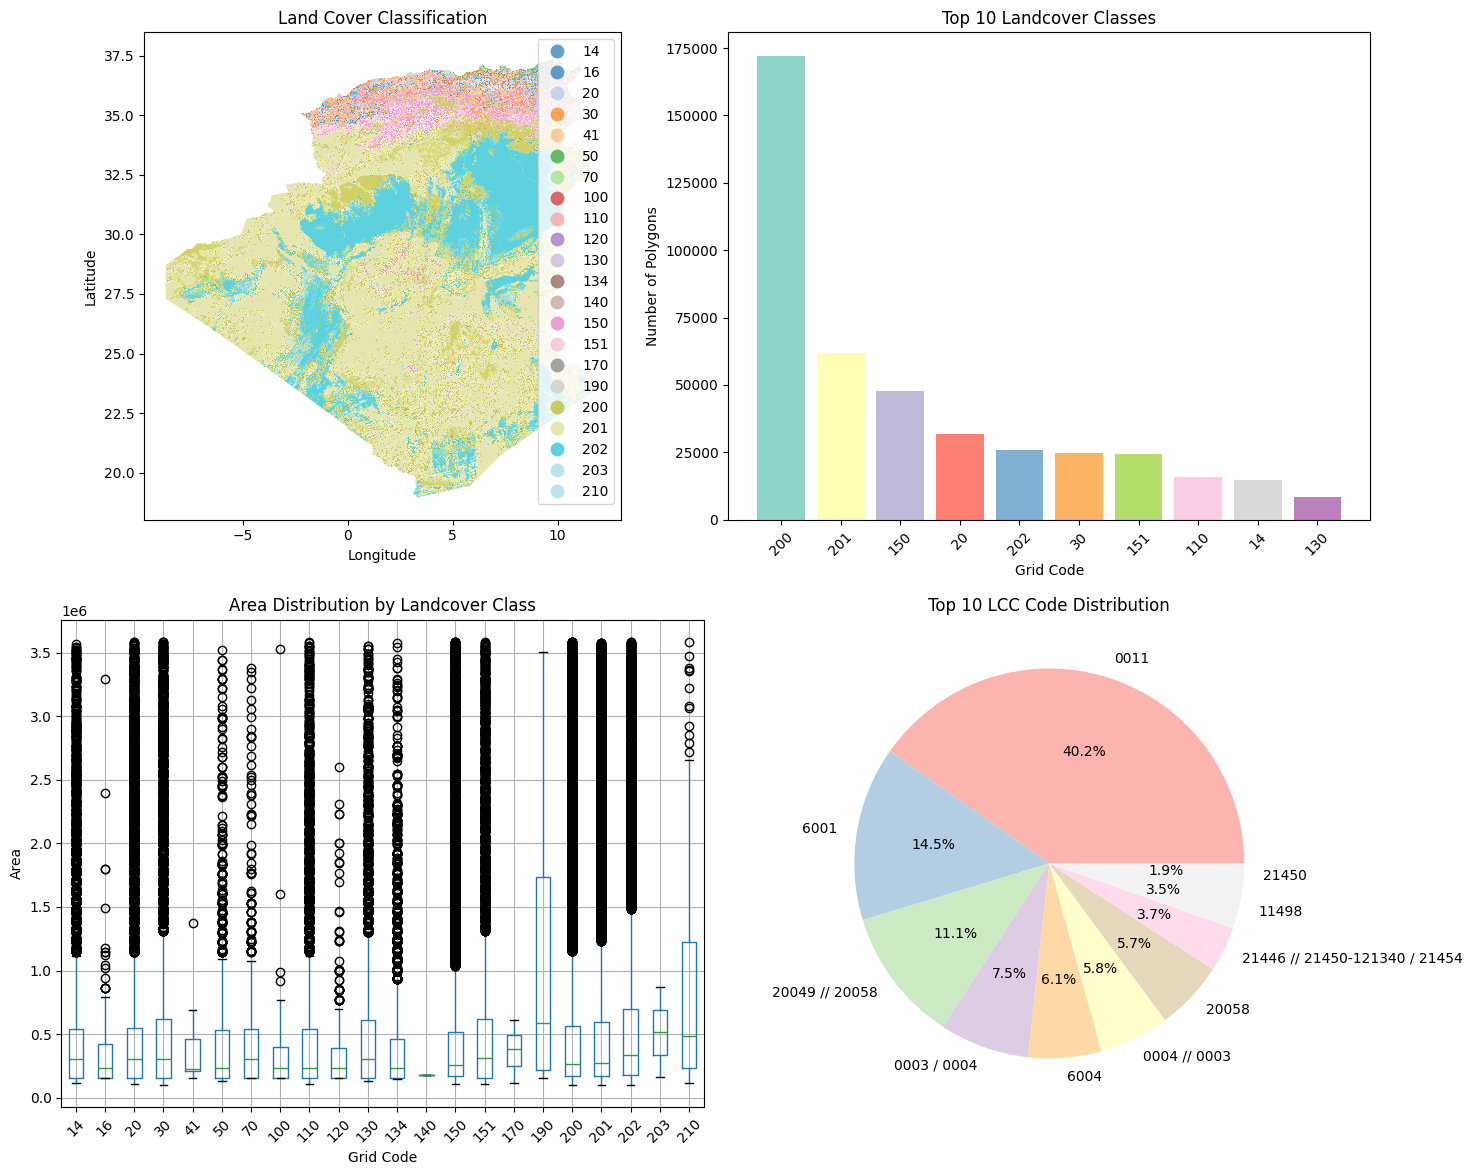

In [27]:
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 5.1 Landcover map
landcover.plot(column='gridcode', ax=axes[0,0], categorical=True, 
               legend=True, cmap='tab20', alpha=0.7)
axes[0,0].set_title("Land Cover Classification")
axes[0,0].set_xlabel("Longitude")
axes[0,0].set_ylabel("Latitude")

# 5.2 Top landcover classes
top_classes = landcover['gridcode'].value_counts().head(10)
axes[0,1].bar(range(len(top_classes)), top_classes.values, 
              color=plt.cm.Set3(range(len(top_classes))))
axes[0,1].set_title("Top 10 Landcover Classes")
axes[0,1].set_xlabel("Grid Code")
axes[0,1].set_ylabel("Number of Polygons")
axes[0,1].set_xticks(range(len(top_classes)))
axes[0,1].set_xticklabels(top_classes.index, rotation=45)

# 5.3 Area distribution by landcover class
landcover_clean = landcover[landcover['area'] < landcover['area'].quantile(0.95)]  # Remove outliers
landcover_clean.boxplot(column='area', by='gridcode', ax=axes[1,0])
axes[1,0].set_title("Area Distribution by Landcover Class")
axes[1,0].set_xlabel("Grid Code")
axes[1,0].set_ylabel("Area")
axes[1,0].tick_params(axis='x', rotation=45)

# 5.4 LCC Code distribution
lcc_counts = landcover['lcccode'].value_counts().head(10)
axes[1,1].pie(lcc_counts.values, labels=lcc_counts.index, autopct='%1.1f%%',
              colors=plt.cm.Pastel1(range(len(lcc_counts))))
axes[1,1].set_title("Top 10 LCC Code Distribution")

plt.suptitle('')  # Remove automatic title from boxplot
plt.tight_layout()
plt.show()

# Elevation Dataset Visualization

C:\Users\ASUS\AppData\Local\Temp\ipykernel_14728\3871835618.py:30: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elev_by_lat = df_elev[df_elev['elevation'] > -1000].groupby(lat_bins)['elevation'].mean()


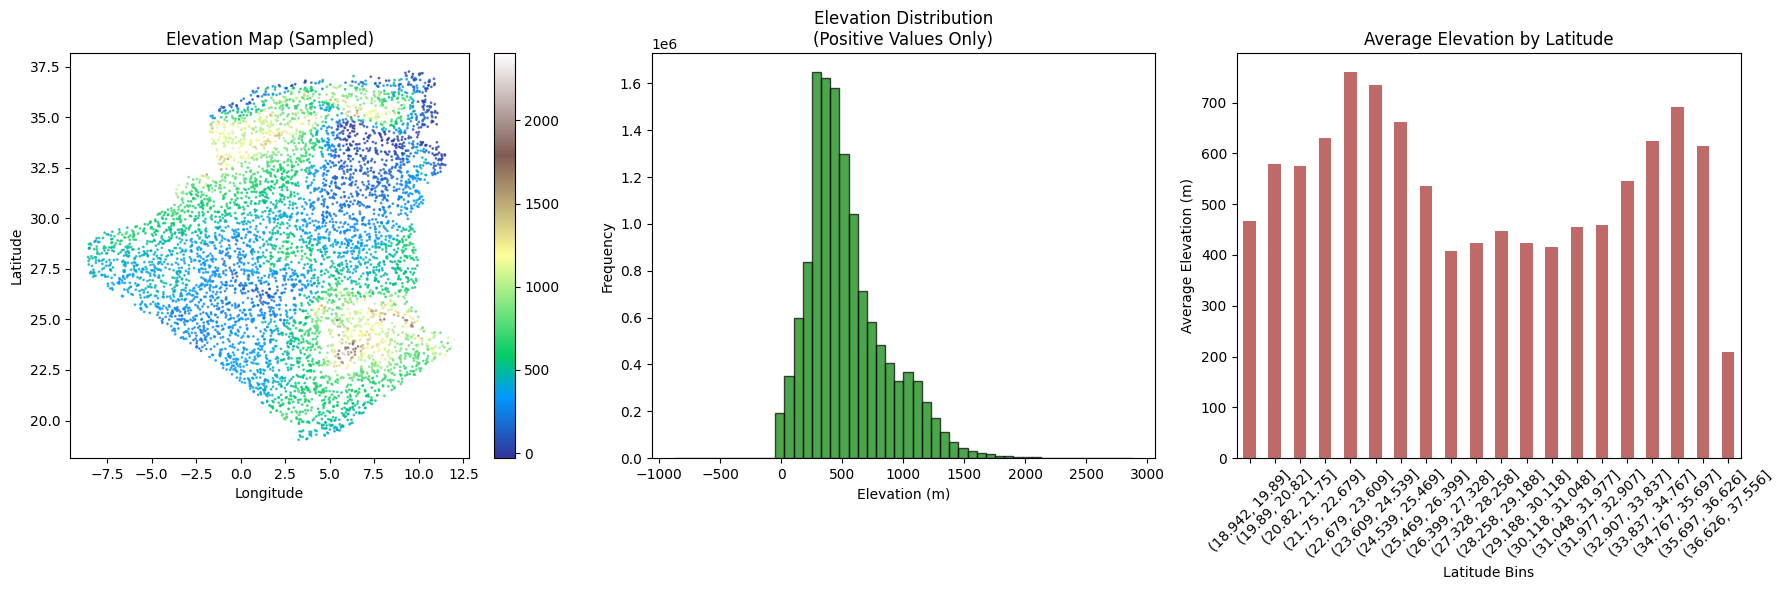

In [28]:
# Sample the data for better visualization (too many points)
elev_sample = df_elev.sample(n=10000, random_state=42)

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# 3.1 Elevation map (sampled)
elev_gdf = gpd.GeoDataFrame(
    elev_sample, 
    geometry=gpd.points_from_xy(elev_sample.lon, elev_sample.lat), 
    crs="EPSG:4326"
)

# Filter out extreme negative values (likely missing data)
elev_positive = elev_gdf[elev_gdf['elevation'] > -1000]
elev_positive.plot(column='elevation', ax=axes[0], legend=True, 
                   cmap='terrain', markersize=1, alpha=0.7)
axes[0].set_title("Elevation Map (Sampled)")
axes[0].set_xlabel("Longitude")
axes[0].set_ylabel("Latitude")

# 3.2 Elevation distribution (positive values only)
positive_elev = df_elev[df_elev['elevation'] > -1000]['elevation']
axes[1].hist(positive_elev, bins=50, color='green', alpha=0.7, edgecolor='black')
axes[1].set_title("Elevation Distribution\n(Positive Values Only)")
axes[1].set_xlabel("Elevation (m)")
axes[1].set_ylabel("Frequency")

# 3.3 Elevation profile by latitude
lat_bins = pd.cut(df_elev[df_elev['elevation'] > -1000]['lat'], bins=20)
elev_by_lat = df_elev[df_elev['elevation'] > -1000].groupby(lat_bins)['elevation'].mean()
elev_by_lat.plot(kind='bar', ax=axes[2], color='brown', alpha=0.7)
axes[2].set_title("Average Elevation by Latitude")
axes[2].set_xlabel("Latitude Bins")
axes[2].set_ylabel("Average Elevation (m)")
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


In [29]:
# Create a correlation matrix for numeric variables across datasets
print("Key Statistics Summary:")
print("="*50)
print(f"Fire dataset: {fire.shape[0]:,} fire events")
print(f"Climate dataset: {climate_df.shape[0]:,} climate records") 
print(f"Elevation dataset: {df_elev.shape[0]:,} elevation points")
print(f"Soil dataset: {layers.shape[0]:,} soil samples")
print(f"Landcover dataset: {landcover.shape[0]:,} landcover polygons")

Key Statistics Summary:
Fire dataset: 90,250 fire events
Climate dataset: 393,492 climate records
Elevation dataset: 22,146,400 elevation points
Soil dataset: 861 soil samples
Landcover dataset: 438,513 landcover polygons


# Fire EDA 

FIRE DATASET EDA


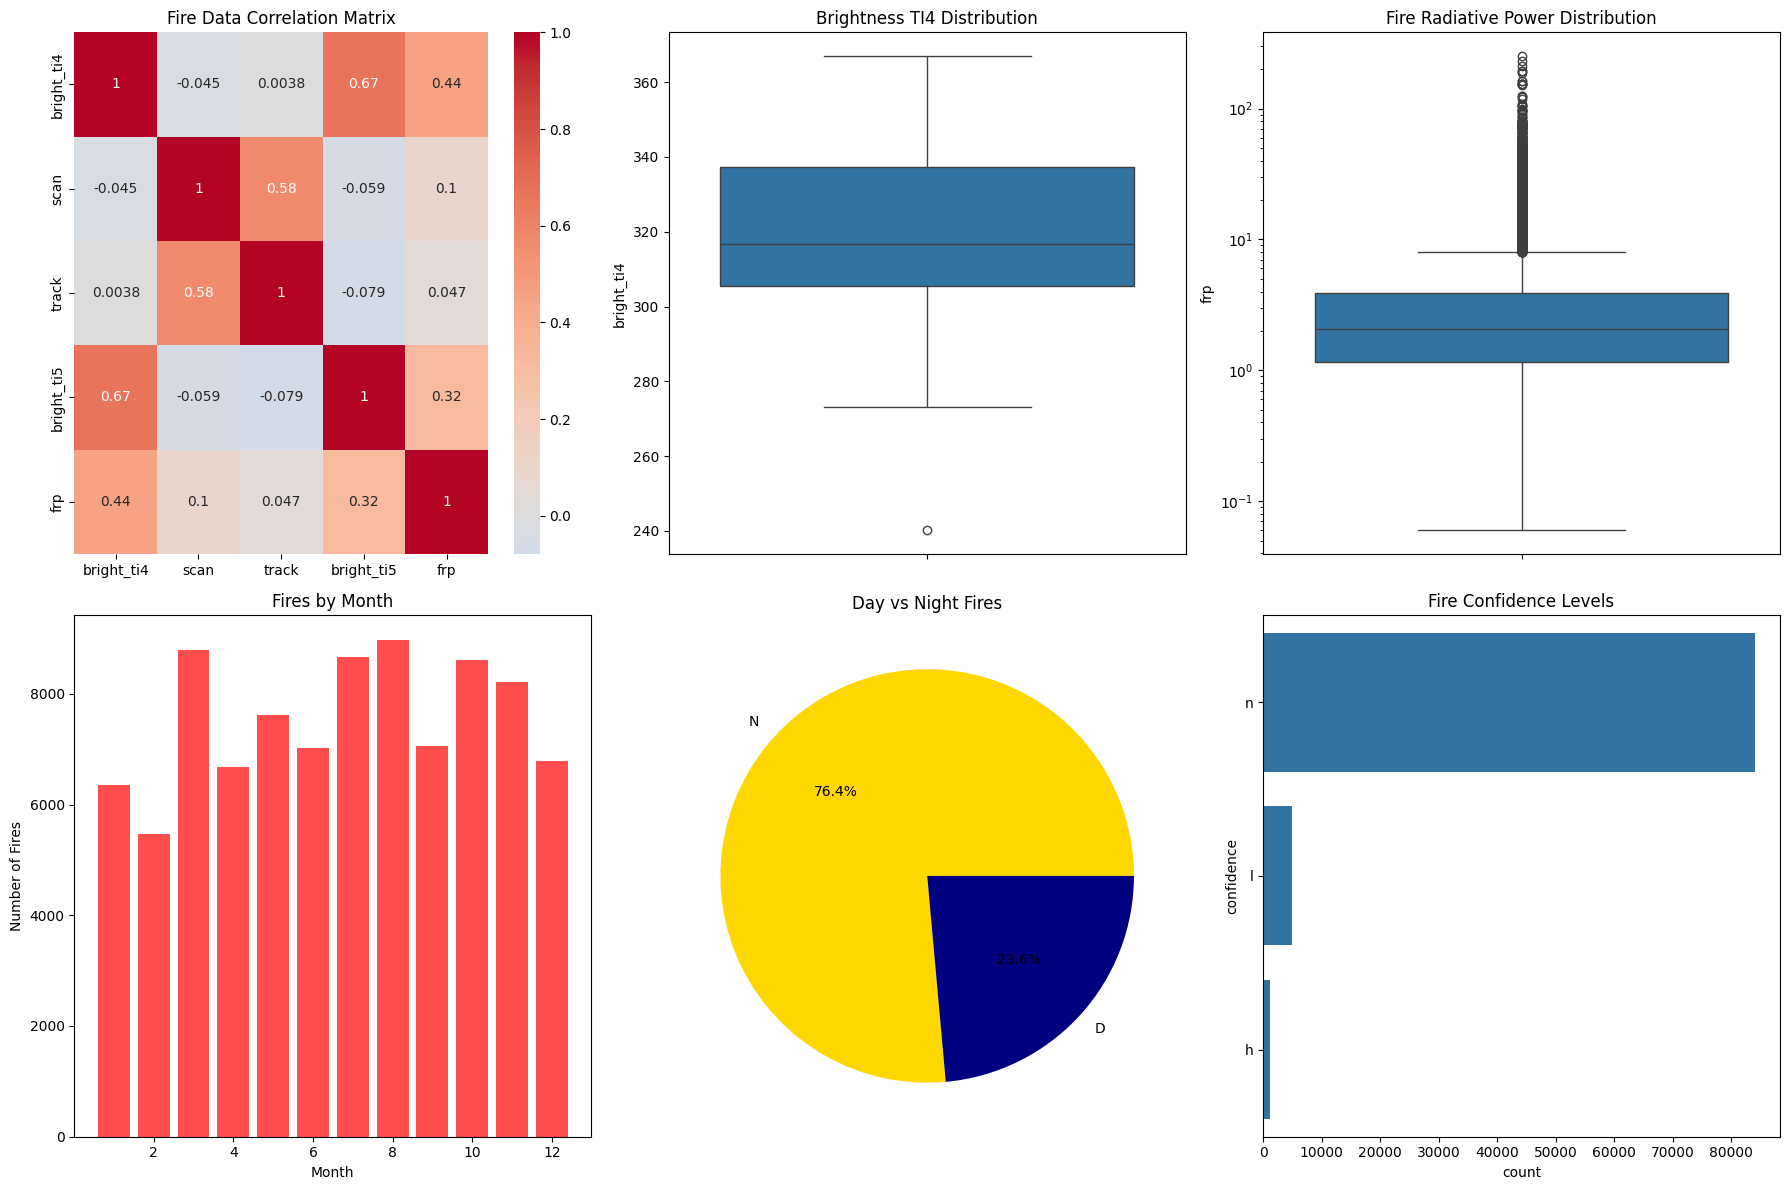


Fire Data Statistical Summary:
         bright_ti4          scan         track    bright_ti5           frp
count  90250.000000  90250.000000  90250.000000  90250.000000  90250.000000
mean     321.091793      0.475991      0.515446    291.726092      3.447776
std       18.205551      0.101596      0.126508     11.700269      5.222111
min      240.170000      0.320000      0.360000    244.790000      0.060000
25%      305.380000      0.400000      0.390000    282.900000      1.150000
50%      316.710000      0.450000      0.490000    290.790000      2.060000
75%      337.400000      0.540000      0.620000    298.100000      3.920000
max      367.000000      0.800000      0.780000    355.420000    251.890000

Categorical Variables:
Day/Night: daynight
N    68979
D    21271
Name: count, dtype: int64
Confidence: confidence
n    84128
l     5013
h     1109
Name: count, dtype: int64
Satellite: satellite
N20    90250
Name: count, dtype: int64


In [31]:
# Fire Dataset EDA
print("="*50)
print("FIRE DATASET EDA")
print("="*50)

# Convert date and create time features
fire['acq_date'] = pd.to_datetime(fire['acq_date'])
fire['month'] = fire['acq_date'].dt.month
fire['year'] = fire['acq_date'].dt.year
fire['day_of_year'] = fire['acq_date'].dt.dayofyear

# Select numeric columns for analysis
fire_numeric = fire.select_dtypes(include=['float64', 'int64'])
fire_numeric = fire_numeric[['bright_ti4', 'scan', 'track', 'bright_ti5', 'frp']]

# Create EDA plots
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1.1 Correlation Matrix
corr_matrix = fire_numeric.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, ax=axes[0,0])
axes[0,0].set_title('Fire Data Correlation Matrix')

# 1.2 Boxplots for key variables
sns.boxplot(data=fire, y='bright_ti4', ax=axes[0,1])
axes[0,1].set_title('Brightness TI4 Distribution')

sns.boxplot(data=fire, y='frp', ax=axes[0,2])
axes[0,2].set_title('Fire Radiative Power Distribution')
axes[0,2].set_yscale('log')

# 1.3 Temporal analysis
monthly_fires = fire.groupby('month').size()
axes[1,0].bar(monthly_fires.index, monthly_fires.values, color='red', alpha=0.7)
axes[1,0].set_title('Fires by Month')
axes[1,0].set_xlabel('Month')
axes[1,0].set_ylabel('Number of Fires')

# 1.4 Day/Night distribution
daynight_counts = fire['daynight'].value_counts()
axes[1,1].pie(daynight_counts.values, labels=daynight_counts.index, autopct='%1.1f%%', 
              colors=['gold', 'navy'])
axes[1,1].set_title('Day vs Night Fires')

# 1.5 Confidence levels
confidence_order = fire['confidence'].value_counts().index
sns.countplot(data=fire, y='confidence', order=confidence_order, ax=axes[1,2])
axes[1,2].set_title('Fire Confidence Levels')

plt.tight_layout()
plt.show()

# Additional statistical summary
print("\nFire Data Statistical Summary:")
print(fire_numeric.describe())
print(f"\nCategorical Variables:")
print(f"Day/Night: {fire['daynight'].value_counts()}")
print(f"Confidence: {fire['confidence'].value_counts()}")
print(f"Satellite: {fire['satellite'].value_counts()}")

# Climate EDA 


CLIMATE DATASET EDA


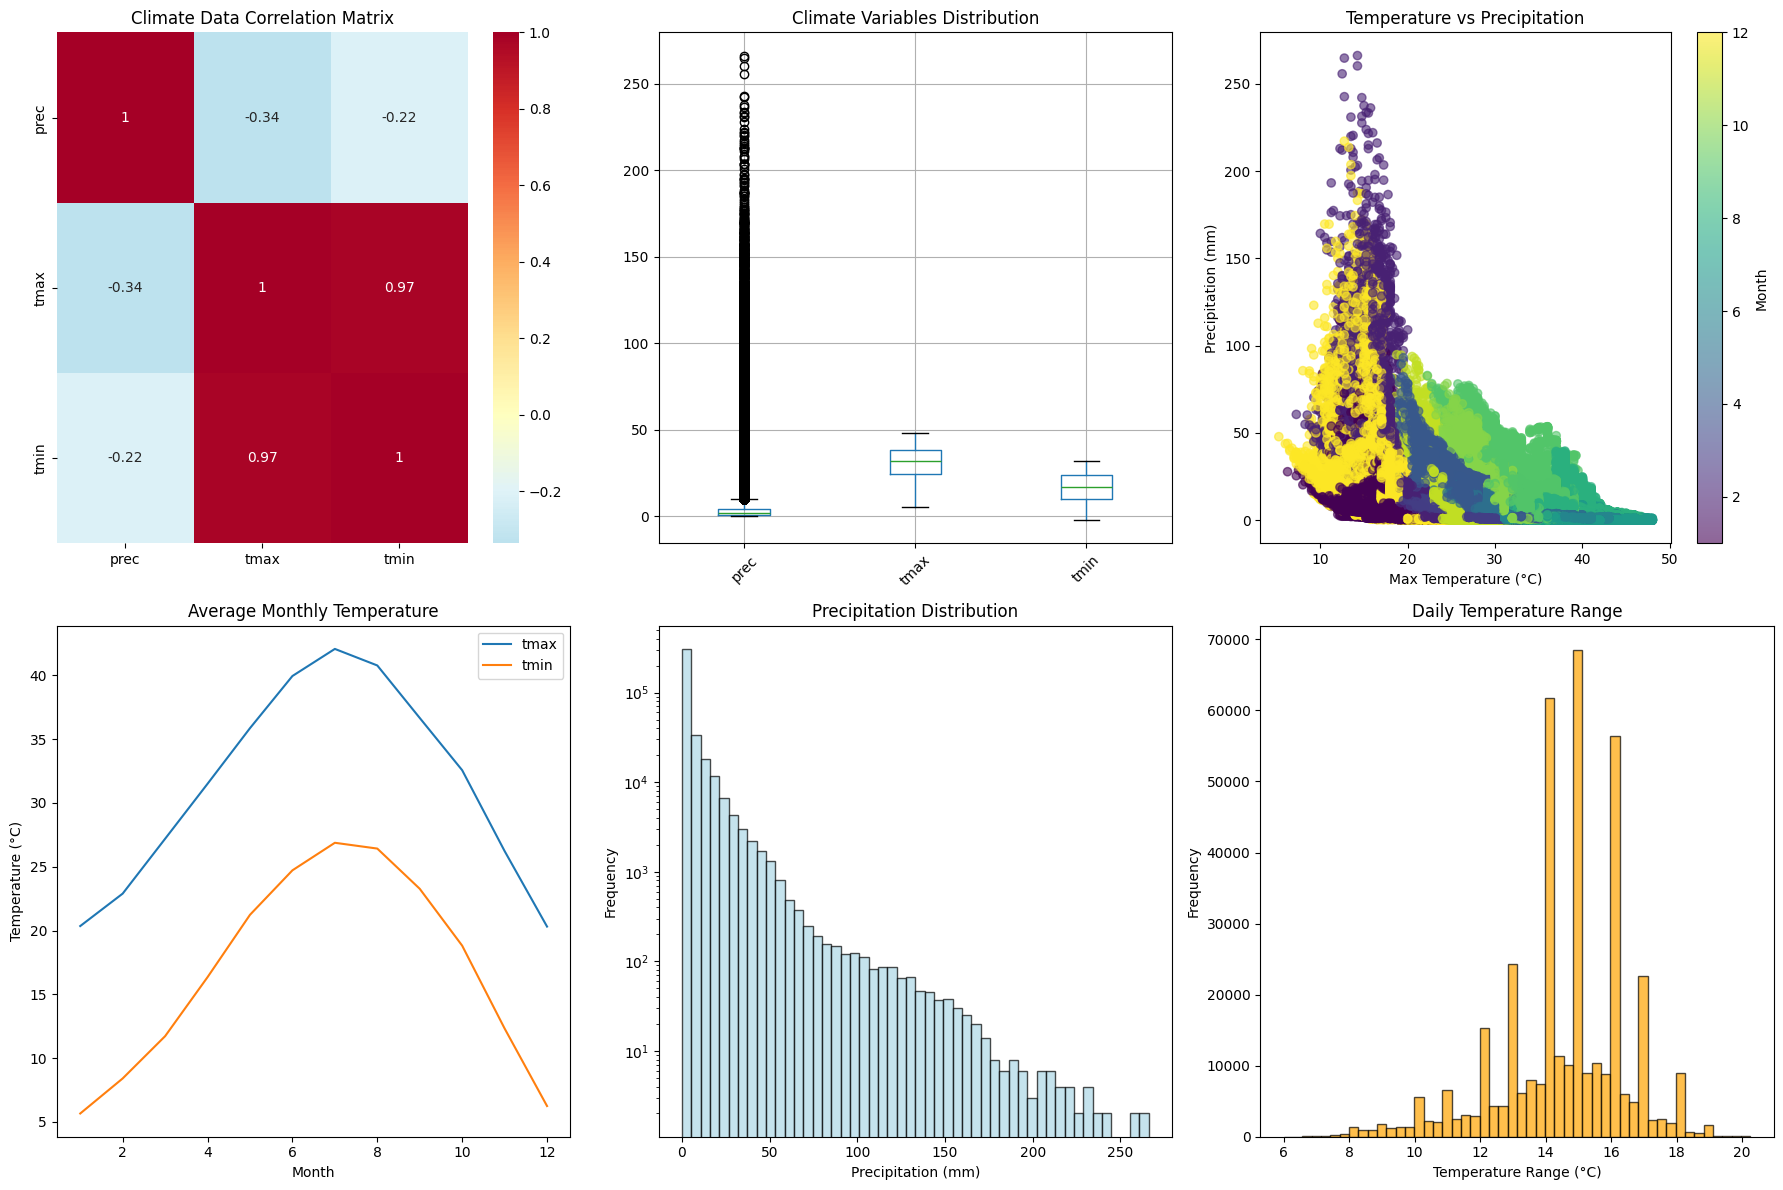


Climate Data Statistical Summary:
                prec           tmax           tmin
count  393492.000000  393492.000000  393492.000000
mean        5.293808      31.360678      16.837290
std        11.140022       8.545506       8.058468
min         0.000000       5.250000      -2.250000
25%         0.800000      24.250000      10.000000
50%         1.700000      32.000000      17.000000
75%         4.425000      38.250000      24.000000
max       266.149994      48.000000      32.000000


In [32]:
# Climate Dataset EDA
print("\n" + "="*50)
print("CLIMATE DATASET EDA")
print("="*50)

# Create time features
climate_df['month'] = climate_df['date'].dt.month
climate_df['day_of_year'] = climate_df['date'].dt.dayofyear

# Select numeric columns
climate_numeric = climate_df[['prec', 'tmax', 'tmin']]

# Create EDA plots
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 2.1 Correlation Matrix
corr_matrix = climate_numeric.corr()
sns.heatmap(corr_matrix, annot=True, cmap='RdYlBu_r', center=0, ax=axes[0,0])
axes[0,0].set_title('Climate Data Correlation Matrix')

# 2.2 Boxplots
climate_numeric.boxplot(ax=axes[0,1])
axes[0,1].set_title('Climate Variables Distribution')
axes[0,1].tick_params(axis='x', rotation=45)

# 2.3 Temperature vs Precipitation scatter
scatter = axes[0,2].scatter(climate_df['tmax'], climate_df['prec'], 
                           c=climate_df['month'], cmap='viridis', alpha=0.6)
axes[0,2].set_xlabel('Max Temperature (°C)')
axes[0,2].set_ylabel('Precipitation (mm)')
axes[0,2].set_title('Temperature vs Precipitation')
plt.colorbar(scatter, ax=axes[0,2], label='Month')

# 2.4 Time series of temperature
monthly_avg = climate_df.groupby('month')[['tmax', 'tmin']].mean()
monthly_avg.plot(ax=axes[1,0])
axes[1,0].set_title('Average Monthly Temperature')
axes[1,0].set_xlabel('Month')
axes[1,0].set_ylabel('Temperature (°C)')

# 2.5 Precipitation distribution
axes[1,1].hist(climate_df['prec'], bins=50, color='lightblue', alpha=0.7, edgecolor='black')
axes[1,1].set_title('Precipitation Distribution')
axes[1,1].set_xlabel('Precipitation (mm)')
axes[1,1].set_ylabel('Frequency')
axes[1,1].set_yscale('log')

# 2.6 Temperature range
climate_df['temp_range'] = climate_df['tmax'] - climate_df['tmin']
axes[1,2].hist(climate_df['temp_range'], bins=50, color='orange', alpha=0.7, edgecolor='black')
axes[1,2].set_title('Daily Temperature Range')
axes[1,2].set_xlabel('Temperature Range (°C)')
axes[1,2].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

print("\nClimate Data Statistical Summary:")
print(climate_numeric.describe())

# Soil EDA


SOIL DATASET EDA


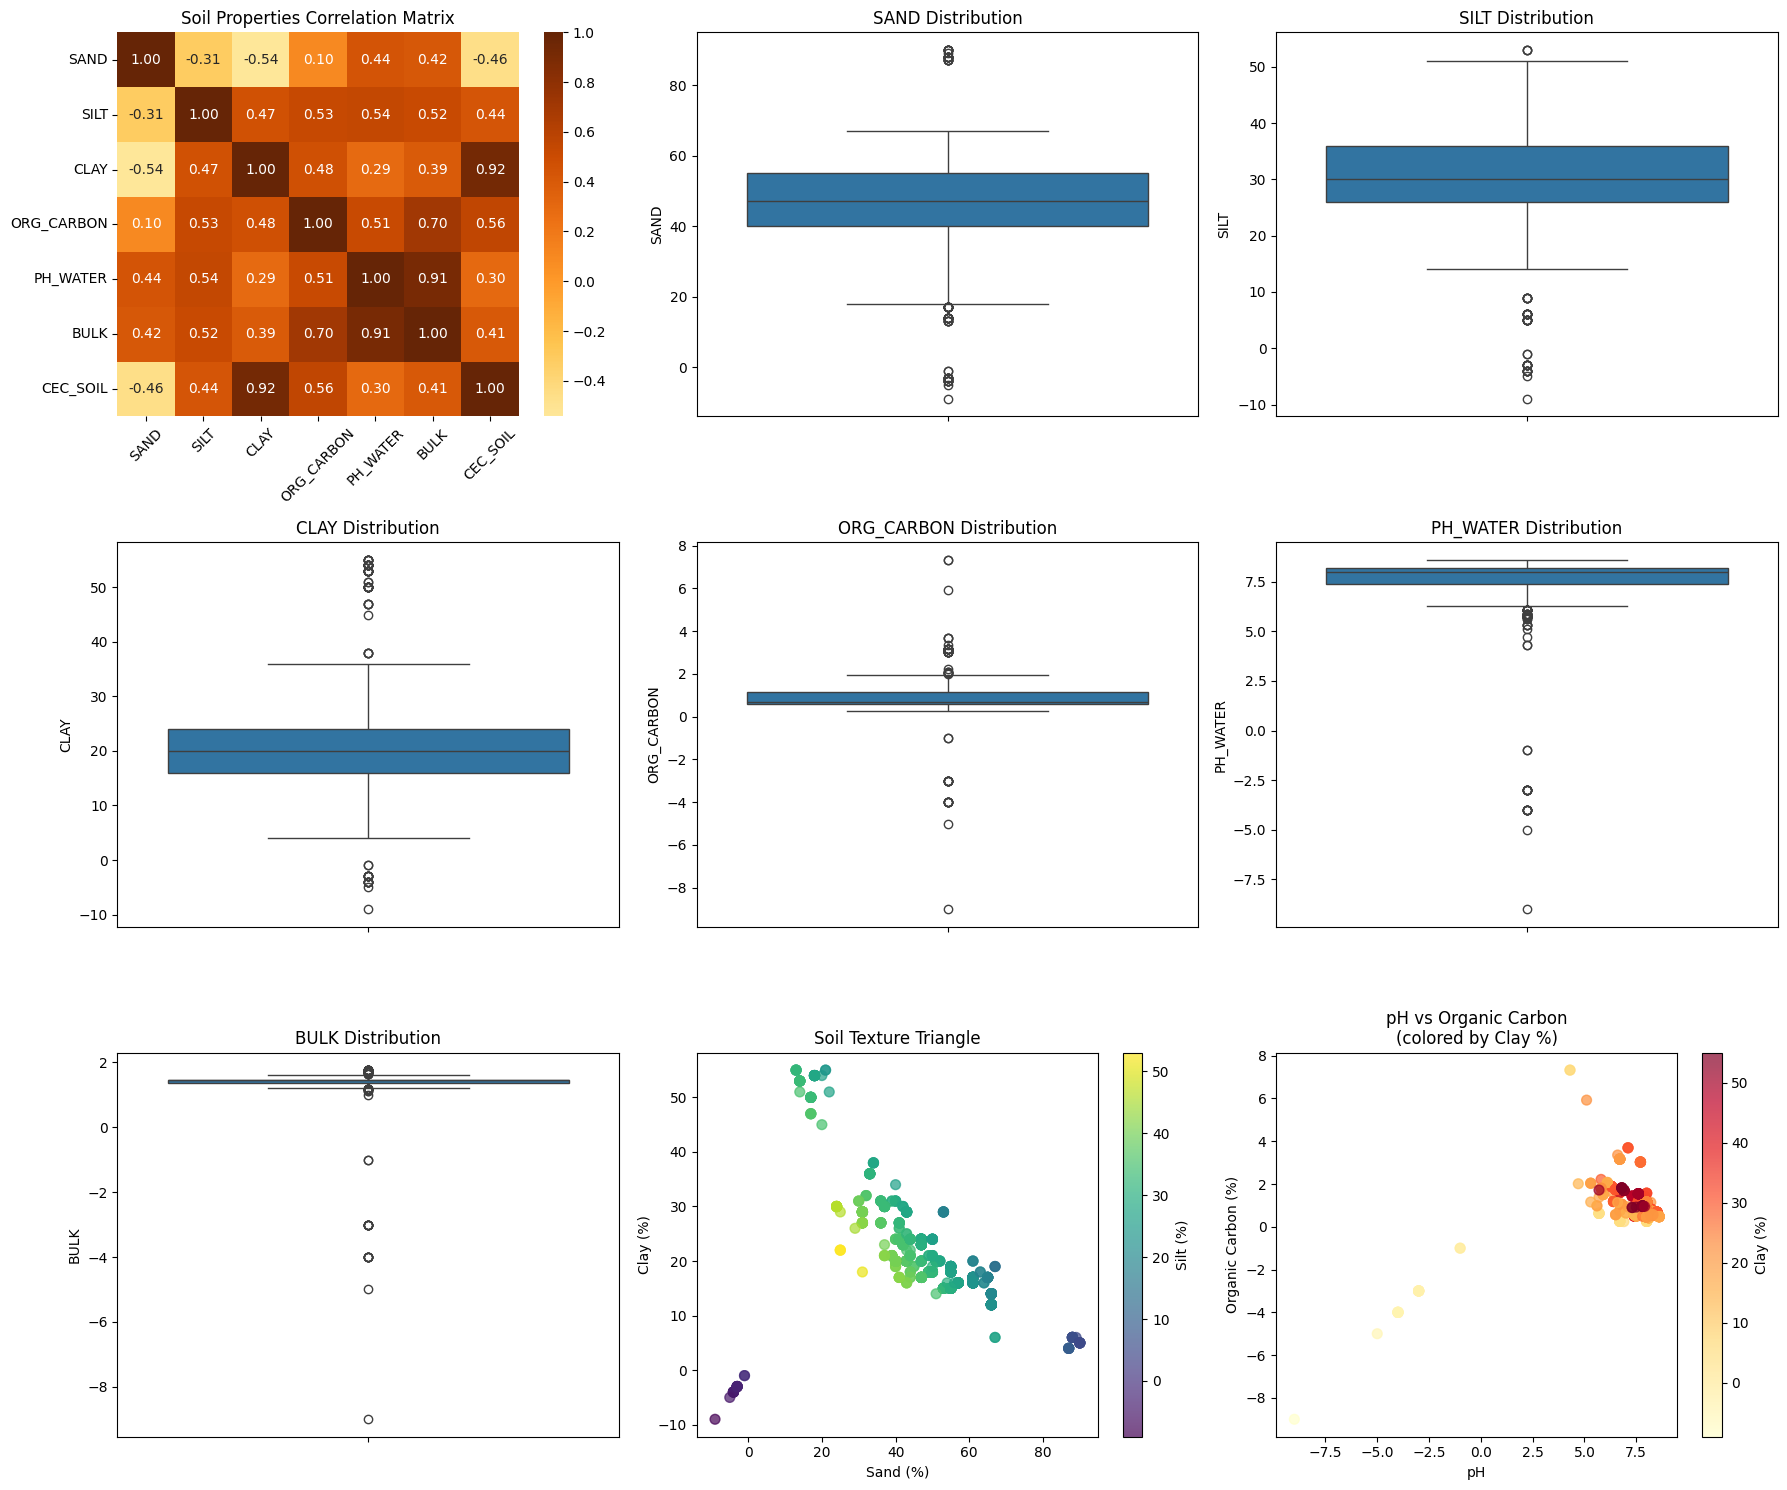


Soil Data Statistical Summary:
             SAND        SILT        CLAY  ORG_CARBON    PH_WATER        BULK  \
count  861.000000  861.000000  861.000000  861.000000  861.000000  861.000000   
mean    46.955865   29.397213   21.203252    0.830069    7.449129    1.318780   
std     16.134836    9.079760   10.372562    0.968955    1.803727    0.780874   
min     -9.000000   -9.000000   -9.000000   -9.000000   -9.000000   -9.000000   
25%     40.000000   26.000000   16.000000    0.589000    7.400000    1.370000   
50%     47.000000   30.000000   20.000000    0.697000    8.000000    1.440000   
75%     55.000000   36.000000   24.000000    1.136000    8.200000    1.470000   
max     90.000000   53.000000   55.000000    7.326000    8.600000    1.760000   

         CEC_SOIL  
count  861.000000  
mean    15.344948  
std      7.651307  
min     -9.000000  
25%     13.000000  
50%     14.000000  
75%     17.000000  
max     41.000000  

Key Correlations:
SAND vs CLAY: -0.543
SAND vs SILT: -0.3

In [33]:
# Soil Dataset EDA
print("\n" + "="*50)
print("SOIL DATASET EDA")
print("="*50)

# Select key soil properties
soil_properties = ['SAND', 'SILT', 'CLAY', 'ORG_CARBON', 'PH_WATER', 'BULK', 'CEC_SOIL']
soil_numeric = layers[soil_properties]

# Create EDA plots
fig, axes = plt.subplots(3, 3, figsize=(18, 15))
axes = axes.ravel()

# 4.1 Correlation Matrix
corr_matrix = soil_numeric.corr()
sns.heatmap(corr_matrix, annot=True, cmap='YlOrBr', center=0, ax=axes[0], fmt='.2f')
axes[0].set_title('Soil Properties Correlation Matrix')
axes[0].tick_params(axis='x', rotation=45)
axes[0].tick_params(axis='y', rotation=0)

# 4.2-4.7 Boxplots for each soil property
for i, prop in enumerate(soil_properties[:6]):
    sns.boxplot(data=layers, y=prop, ax=axes[i+1])
    axes[i+1].set_title(f'{prop} Distribution')

# 4.8 Soil texture triangle (simplified)
scatter = axes[7].scatter(layers['SAND'], layers['CLAY'], c=layers['SILT'], 
                         cmap='viridis', alpha=0.7, s=50)
axes[7].set_xlabel('Sand (%)')
axes[7].set_ylabel('Clay (%)')
axes[7].set_title('Soil Texture Triangle')
plt.colorbar(scatter, ax=axes[7], label='Silt (%)')

# 4.9 pH vs Organic Carbon
scatter = axes[8].scatter(layers['PH_WATER'], layers['ORG_CARBON'], 
                         c=layers['CLAY'], cmap='YlOrRd', alpha=0.7, s=50)
axes[8].set_xlabel('pH')
axes[8].set_ylabel('Organic Carbon (%)')
axes[8].set_title('pH vs Organic Carbon\n(colored by Clay %)')
plt.colorbar(scatter, ax=axes[8], label='Clay (%)')

plt.tight_layout()
plt.show()

# Additional analysis
print("\nSoil Data Statistical Summary:")
print(soil_numeric.describe())

# Check for correlations with texture
print(f"\nKey Correlations:")
print(f"SAND vs CLAY: {layers['SAND'].corr(layers['CLAY']):.3f}")
print(f"SAND vs SILT: {layers['SAND'].corr(layers['SILT']):.3f}")
print(f"CLAY vs SILT: {layers['CLAY'].corr(layers['SILT']):.3f}")